In [54]:
# from google.colab import drive
# drive.mount('/content/drive')

In [55]:
import glob
import pandas as pd
import numpy as np
import requests
#import html5lib
from bs4 import BeautifulSoup
import datetime
import re

In [56]:
def percentage(part, whole):
    return 100 * float(part)/float(whole)

In [57]:
# !ls '/content/drive/My Drive/database'
# these paths are configured to read the database from google drive
tweets_path = '/content/drive/My Drive/database/Tweets/bitcoin/'
bitcoin_file = '/content/drive/My Drive/database/bitcoinHistoricalData/bitcoin.csv'
crypto_name = 'bitcoin' # bitcoin, ethereum, bitcoincash, ripple or litecoin


In [58]:
# initializing dataframes
df_noOfTweets = pd.DataFrame(columns=['date','positive', 'neutral', 'negative', 'total']) # for the barchart of no. of tweets
df_polarity_line = pd.DataFrame(columns=['date','polarity']) # for the polarity line chart

# Tweets about each crypto is taken from saved txt files with dates ranging from 2017-09-01 to 2017-11-30
# Tweets are collected by selenium automated script written in python
for f in glob.glob( str(tweets_path) + crypto_name + '*.txt'):
    df_datawise = pd.read_csv(f, sep='\t', encoding='utf-8', parse_dates=True)
    polarity = 0.00
    neutral = positive = negative = 0
    for idx,row in df_datawise.iterrows():
        polarity += float(row["polarity"])
        
        # adding reaction of how people are reacting to find average later
        if (float(row["polarity"]) >= -0.1 and float(row["polarity"]) <= 0.1):  
            neutral += 1
        elif (float(row["polarity"]) > 0.1):
            positive += 1
        elif (float(row["polarity"]) <-0.1):
            negative += 1
    positive = percentage(positive, len(df_datawise.index))
    negative = percentage(negative, len(df_datawise.index))
    neutral = percentage(neutral, len(df_datawise.index))
    # below df format is for barchart with sentiments
    df_temp_df_noOfTweets = pd.DataFrame({'date': df_datawise.iloc[0]['date'], 'positive': ((positive/100)*len(df_datawise.index)),'neutral': ((neutral/100)*len(df_datawise.index)), 'negative': ((negative/100)*len(df_datawise.index)), 'total': len(df_datawise.index)}, index=[0])
    # print(df_temp_df_noOfTweets)
    # polarity /= df_temp_df_noOfTweets['total']
    df_noOfTweets = df_noOfTweets.append(df_temp_df_noOfTweets,sort=True, ignore_index=True)
    
    # below df format is for polarity_line with sentiments
    df_temp_polarity_line = pd.DataFrame({'date': df_datawise.iloc[0]['date'], 'polarity': polarity}, index=[0])
    df_polarity_line = df_polarity_line.append(df_temp_polarity_line, sort=True, ignore_index=True)

df_noOfTweets = df_noOfTweets.sort_values(by = 'date')
df_noOfTweets.reset_index(inplace=True)
required_tweets = ['date','positive','neutral','negative','total']
df_noOfTweets = df_noOfTweets[required_tweets]

df_polarity_line = df_polarity_line.sort_values(by = 'date')
df_polarity_line.reset_index(inplace=True)
required_polarity = ['date','polarity']
df_polarity_line = df_polarity_line[required_polarity]
print(df_polarity_line)    

          date    polarity
0   2017-09-01   44.841279
1   2017-09-02   34.723938
2   2017-09-03   30.123810
3   2017-09-04   43.906721
4   2017-09-05   51.609893
..         ...         ...
86  2017-11-26  102.080079
87  2017-11-27  135.689441
88  2017-11-28  126.736091
89  2017-11-29  171.530026
90  2017-11-30  119.289935

[91 rows x 2 columns]


In [59]:
# print table of positive, negative, neutral tweets
import plotly
import plotly.figure_factory as ff

table = ff.create_table(df_noOfTweets)
plotly.offline.iplot(table, filename='df_noOfTweets')

In [60]:
import plotly.graph_objs as go
from plotly.offline import *

trace1 = go.Scatter(
    x=df_noOfTweets['date'],
    y=df_noOfTweets['total'],
    mode = 'lines',
    name='No. Of Tweets'
)

#total number of tweets in dataset
print(df_noOfTweets['total'].sum())

trace2 = go.Scatter(
    x=df_noOfTweets['date'],
    y=df_noOfTweets['neutral'],
    mode = 'lines',
    name='Neutral'
)
trace3 = go.Scatter(
    x=df_noOfTweets['date'],
    y=df_noOfTweets['positive'],
    mode = 'lines',
    name='Positive'
)
trace4 = go.Scatter(
    x=df_noOfTweets['date'],
    y=df_noOfTweets['negative'],
    mode = 'lines',
    name='Negative'
)
data = [trace1, trace2, trace3, trace4]
layout = go.Layout(
    title='Number of Tweets'
)
fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig, filename='No_Of_Tweets.html') # Plot No. of Tweets


54827


In [61]:
# bitcoin_file = '/content/drive/My Drive/database/bitcoinHistoricalData/bitcoin.csv'
data = pd.read_csv(bitcoin_file)
req_features = ['Timestamp','Close']
df_bitcoin = pd.DataFrame(columns=['date','close'])
frequency=0
sum=0
cur_date=""
for index in data.index:
  date = data['Timestamp'][index]
  date = date.split(' ')[0]
  value = float(data['Close'][index])
  if date != cur_date:
    if cur_date != "":
      sum = sum/frequency
      temp = pd.DataFrame({"date":[cur_date], "close":[sum]}) 
      df_bitcoin = df_bitcoin.append(temp, ignore_index = True)
    cur_date = date
    frequency = 1
    sum = value
  else:
    sum += value
    frequency += 1  
sum = sum/frequency
temp = pd.DataFrame({"date":[cur_date], "close":[sum]}) 
df_bitcoin = df_bitcoin.append(temp, ignore_index = True)
# print(df_bitcoin)
df_bitcoin = pd.merge(df_bitcoin, df_polarity_line,left_on='date', right_on='date')
table = ff.create_table(df_bitcoin)
plotly.offline.iplot(table, filename='df_bitcoin')
# print(df_bitcoin.shape)

In [62]:
# ============================================== #
# Plot Polarity, Price in USD(Close) and Volume  #
# ============================================== #
trace1 = go.Scatter(
    x=df_bitcoin['date'],
    y=df_bitcoin['close'],
    mode = 'lines',
    name='Closing Price'
)
trace2 = go.Scatter(
    x=df_bitcoin['date'],
    y=df_bitcoin['polarity'],
    mode = 'lines',
    name='Polarity',
    yaxis='y2'
)
data = [trace1, trace2]
layout = go.Layout(
    title='Sentiment Polarity Vs. Closing Price (in USD)',
    yaxis=dict(
        title='Closing Price.'
    ),
    yaxis2=dict(
        title='Polarity',
        titlefont=dict(
            color='rgb(148, 103, 189)'
        ),
        tickfont=dict(
            color='rgb(148, 103, 189)'
        ),
        overlaying='y',
        side='right'
    )
)
fig = go.Figure(data=data, layout=layout)

plotly.offline.iplot(fig, filename='Sentiment_vs_Market.html')

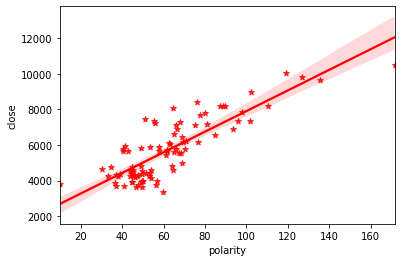

In [67]:
# Regression in polarity vs closing price
import seaborn as sns
import matplotlib as plt
sns.regplot(x=df_bitcoin['polarity'], y=df_bitcoin['close'], color='red', marker='*')

In [64]:
# Calculating the Pearson coefficient
from scipy import stats
pearson_coef, p_value = stats.pearsonr(df_bitcoin['polarity'], df_bitcoin['close'])
print(pearson_coef)

0.8375567867512373


In [65]:
# find skewness of tweets data
skewValue = df_bitcoin.skew(axis=0)
print(skewValue)

close       0.795989
polarity    1.638047
dtype: float64
